In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.jupyter import *

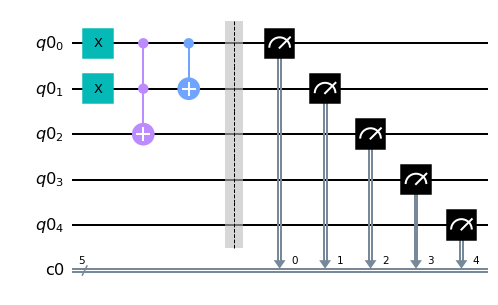

In [2]:
qr = QuantumRegister(5)
cr = ClassicalRegister(5)

qc = QuantumCircuit(qr, cr)
qc.x(qr[0])
qc.x(qr[1])
qc.ccx(qr[0], qr[1], qr[2])
qc.cx(qr[0], qr[1])
qc.barrier()
qc.measure(qr, cr)
qc.draw("mpl")

In [3]:
IBMQ.save_account("7ec7c3d9c61b02577a80462aeed74b169ce4defa242d2b2fc5031cabfac5f8199274a09d822b1dcd65125930a20f7c7c5f147e4785837efcc84764640599e462", overwrite = True)

In [4]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
%qiskit_backend_overview

In [6]:
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_quito')

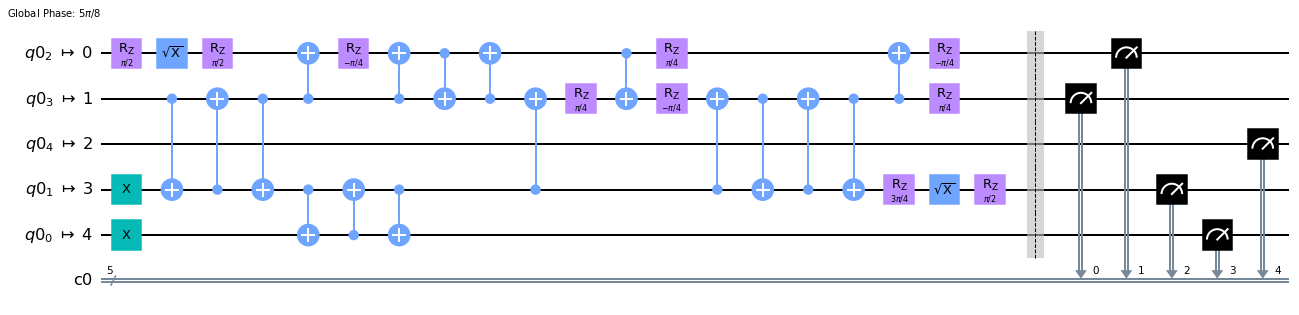

In [7]:
mapped_circuit = transpile(qc, backend)
mapped_circuit.draw("mpl", fold = -1)

In [8]:
qobj = assemble(mapped_circuit, backend, shots = 1024)
job = backend.run(qobj)

C:\Users\ganiy\AppData\Local\Temp\ipykernel_13720\3638761164.py:2: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


In [9]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [10]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [11]:
experiment = execute(mapped_circuit, backend, shots = 1024)

In [12]:
%qiskit_disable_job_watcher

In [13]:
counts = experiment.result().get_counts()

In [14]:
job.job_id()

'63adc434d0cd805e6d96e928'

In [15]:
import json
print(json.dumps(counts, indent=4))

{
    "00000": 13,
    "00001": 60,
    "10000": 1,
    "10001": 3,
    "10010": 1,
    "10011": 8,
    "10100": 2,
    "10101": 41,
    "10111": 4,
    "11001": 1,
    "11011": 1,
    "11101": 2,
    "11110": 1,
    "11111": 1,
    "00010": 27,
    "00011": 57,
    "00100": 24,
    "00101": 638,
    "00110": 22,
    "00111": 70,
    "01000": 4,
    "01001": 6,
    "01010": 6,
    "01011": 8,
    "01100": 2,
    "01101": 15,
    "01110": 2,
    "01111": 4
}


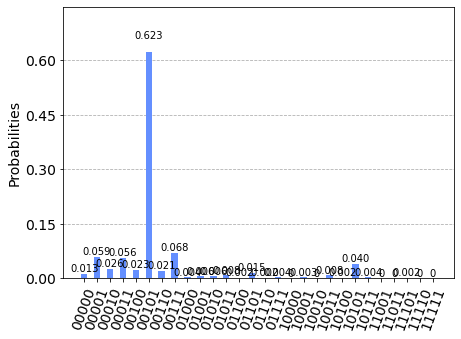

In [16]:
plot_histogram(counts)

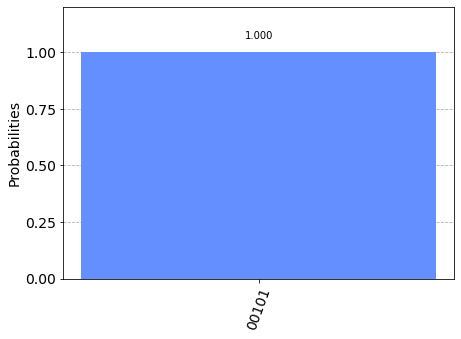

In [17]:
#### Using Aer
aer_backend = Aer.get_backend("qasm_simulator")

new_result = execute(qc, aer_backend, shots = 1024)

plot_histogram(new_result.result().get_counts())

## Quantum Error Mitigation

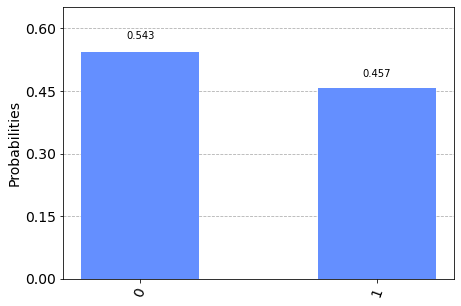

In [18]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure([0],[0])
mapped_circ = transpile(qc, backend)
counts = execute(mapped_circ, backend, shots = 1024).result().get_counts()
plot_histogram(counts)

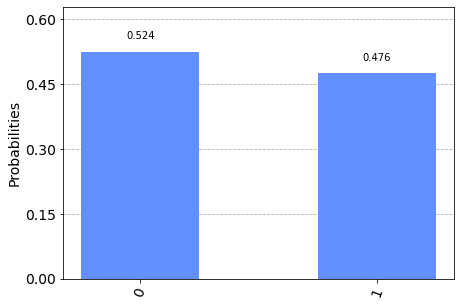

In [19]:
from qiskit.providers.fake_provider import FakeQuito
from qiskit.providers.aer import AerSimulator

device_backend = FakeQuito()

sim_quito = AerSimulator.from_backend(device_backend)

mapped_circuit = transpile(qc, sim_quito)

counts = execute(mapped_circuit, sim_quito, shots = 10000000).result().get_counts()
plot_histogram(counts)

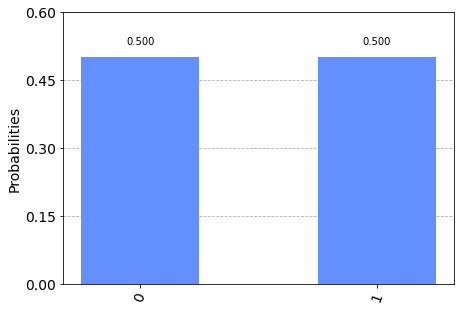

In [20]:
sim_ideal = AerSimulator()

mapped_circuit = transpile(qc, sim_ideal)

counts = execute(mapped_circuit, sim_ideal, shots = 10000000).result().get_counts()
plot_histogram(counts)

In [21]:
shots = 10000000

In [22]:
def prepare_mitigation(calibration):

    def mitigate_counts(newcounts, total_shots, prob_1 = 0.5):
        return {'0': round((total_shots*(1-prob_1)/calibration['0'])*newcounts['0']),'1': round((total_shots*prob_1/calibration['1'])*newcounts['1'])}

    return mitigate_counts

mitigate_counts = prepare_mitigation(counts)

In [23]:
mitigate_counts(counts, shots)

{'0': 5000000, '1': 5000000}

In [24]:
from math import asin, sqrt

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

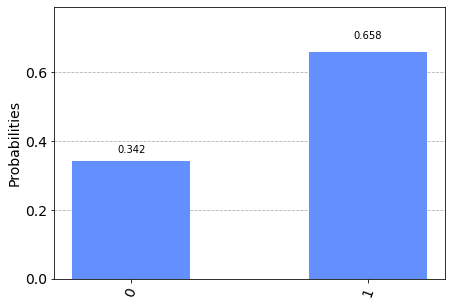

In [25]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
qc.ry(prob_to_angle(0.7), qr[0])
qc.measure(qr, cr)

mapped_circuit = transpile(qc, backend=backend)

# transpile the circuit
mapped_circuit = transpile(qc, backend=sim_quito)

# run the transpiled circuit, no need to assemble it
job = sim_quito.run(mapped_circuit, shots=shots)

result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [26]:
mitigated_counts = mitigate_counts(counts, shots, prob_1 = 0.7)
print("Unmitigated result: {}".format(counts))
print("Mitigated result: {}".format(mitigated_counts))

Unmitigated result: {'1': 6581529, '0': 3418471}
Mitigated result: {'0': 2051972, '1': 9210147}


In [27]:
result = sim_ideal.run(transpile(qc, sim_ideal), shots=10000000).result()
ideal_counts = result.get_counts()
print("Ideal result: {}".format(ideal_counts))

Ideal result: {'1': 6999192, '0': 3000808}


In [28]:
def expectation_value(counts):
    return (counts["0"] - counts["1"])/(counts["0"] + counts["1"])

ev_unmitigated = expectation_value(counts)
ev_mitigated = expectation_value(mitigated_counts)
ev_ideal = expectation_value(ideal_counts)

print(f"EV unmitigated: {ev_unmitigated : .3f}")
print(f"EV mitigated: {ev_mitigated : .3f}")
print(f"EV ideal: {ev_ideal : .3f}")
print()
error_unmitigated = abs(ev_unmitigated-ev_ideal)
error_mitigated = abs(ev_mitigated-ev_ideal)

print(f"Error unmitigated: {error_unmitigated :.3f}")
print(f"Error mitigated: {error_mitigated :.3f}")
print()

print(f"Error reduction: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")

EV unmitigated: -0.316
EV mitigated: -0.636
EV ideal: -0.400

Error unmitigated: 0.084
Error mitigated: 0.236

Error reduction: -182.2%.


### Zero-noise exploitation

In [29]:
from math import pi

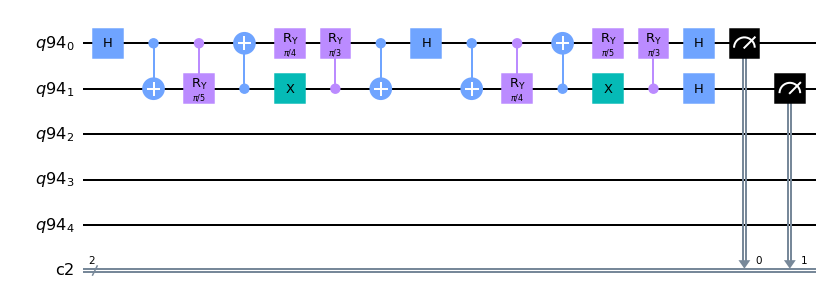

In [30]:
qr = QuantumRegister(5)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)

qc.h(0)
qc.cx(0,1)
qc.cry(pi/5,0,1)
qc.cx(1,0)
qc.ry(pi/4,0)
qc.x(1)
qc.cry(pi/3,1,0)
qc.cx(0,1)
qc.h(0)
qc.cx(0,1)
qc.cry(pi/4,0,1)
qc.cx(1,0)
qc.ry(pi/5,0)
qc.x(1)
qc.cry(pi/3,1,0)
qc.h(0)
qc.h(1)

qc.measure(qr[0], cr[0])
qc.measure(qr[1], cr[1])

qc.draw("mpl")

In [31]:
from mitiq.interface.mitiq_qiskit import qiskit_utils
from mitiq import Observable, PauliString
from qiskit.providers.aer.noise import NoiseModel

obs = Observable(PauliString("ZZZZZ"))
shots = 10000

def sim_quito_noisy(qc):
    return qiskit_utils.execute_with_shots_and_noise(qc,obs.matrix(),NoiseModel.from_backend(backend),shots)

def sim_quito_ideal(qc):
    return qiskit_utils.execute_with_shots(qc,obs.matrix(),shots)

In [32]:
from mitiq import zne

# transpile the circuit
mapped_circuit = transpile(qc, backend=backend)

result_ideal = sim_quito_ideal(mapped_circuit)
result_noisy = sim_quito_noisy(mapped_circuit)
result_mitigated = zne.execute_with_zne(mapped_circuit, sim_quito_noisy)

print(f"EV unmitigated: {result_noisy :.3f}")
print(f"EV mitigated: {result_mitigated :.3f}")
print(f"EV ideal: {result_ideal :.3f}")
print()
error_unmitigated = abs(result_noisy-result_ideal)
error_mitigated = abs(result_mitigated-result_ideal)

print(f"Error unmitigated: {error_unmitigated :.3f}")
print(f"Error mitigated: {error_mitigated :.3f}")
print()
print(f"Error reduction: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")

EV unmitigated: 0.071
EV mitigated: 0.063
EV ideal: 0.505

Error unmitigated: 0.434
Error mitigated: 0.442

Error reduction: -1.8%.


In [33]:
mitigated = zne.execute_with_zne(mapped_circuit, sim_quito_noisy,scale_noise=zne.scaling.fold_global)
print(f"Mitigated result {mitigated:.3f}")

Mitigated result 0.079


In [34]:
linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.4, 1.8,2.2, 2.6, 3.0])
mitigated = zne.execute_with_zne(mapped_circuit, sim_quito_noisy, factory=linear_factory, scale_noise=zne.scaling.fold_gates_from_left)
print(f"Mitigated result {mitigated:.3f}")

Mitigated result 0.080
